# **Quantitative analysis using stock price data and technical indicators**

---
---

### **Setup**

---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator
import talib

### **1. Data Preparation and Cleaning**

----

### Tickers
- AAPL: Apple Inc.
- AMZN: Amazon.com. Inc.
- GOOG: Alphabet Inc. (Class C)
- FB: Meta Platforms, Inc.
- MSF: Microsoft Corporation
- NVDA: NVIDIA Corporation
- TSLA: Tesla, Inc.

In [2]:
# Load a CSV file from your local file system
df_Apple = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/AAPL_historical_data.csv')
df_Amazon = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/AMZN_historical_data.csv')
df_Alphabet = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/GOOG_historical_data.csv')
df_Meta = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/META_historical_data.csv')
df_Microsoft = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/MSFT_historical_data.csv')
df_NVIDIA = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/NVDA_historical_data.csv')
df_TSLA = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/TSLA_historical_data.csv')

# Add a 'Ticker' column to each DataFrame
df_Apple['Ticker'] = 'AAPL'
df_Amazon['Ticker'] = 'AMZN'
df_Alphabet['Ticker'] = 'GOOG'
df_Meta['Ticker'] = 'FB'
df_Microsoft['Ticker'] = 'MSF'
df_NVIDIA['Ticker'] = 'NVDA'
df_TSLA['Ticker'] = 'TSLA'

# Combine all DataFrames into one
df = pd.concat([df_Apple, df_Amazon, df_Alphabet, df_Meta, df_Microsoft, df_NVIDIA, df_TSLA], ignore_index=True)

In [ ]:
# Check for missing values and data types
print(df.info())
print(df.isnull().sum())

# Convert 'date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

# Filter rows where date is from 2020 onwards
df = df[df['Date'] >= '2020-01-01']

# Convert 'Date' column to datetime if not already
df['Date']= pd.to_datetime(df['Date'], errors='coerce')


# Drop rows with missing or invalid dates
df = df.dropna(subset=['Date'])


# Ensure numeric columns are correct type
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


# Drop rows with any remaining missing values in critical columns
df = df.dropna(subset=numeric_cols)


# Reset index after cleaning
df = df.reset_index(drop=True)


# Save the cleaned dataframe to a local CSV file
df.to_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/historical_data_of_all_tickers_cleaned.csv', index=False)


# Display cleaned dataframe info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45428 entries, 0 to 45427
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          45428 non-null  object 
 1   Open          45428 non-null  float64
 2   High          45428 non-null  float64
 3   Low           45428 non-null  float64
 4   Close         45428 non-null  float64
 5   Adj Close     45428 non-null  float64
 6   Volume        45428 non-null  int64  
 7   Dividends     45428 non-null  float64
 8   Stock Splits  45428 non-null  float64
 9   Ticker        45428 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 3.5+ MB
None
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
Ticker          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8057 entries, 0 to 8056
Data columns (total 10 columns):
 #   Col

### **Summary of Data Preparation**

The data preparation process for the stock price dataset included the following steps:

- **Missing Values & Data Types:** Checked for missing values and verified data types for all columns. The combined DataFrame `df` contains no missing values in critical columns.
- **Date Conversion:** Converted the 'Date' column to `datetime64[ns]` format for accurate time series analysis.
- **Numeric Columns:** Ensured all price and volume-related columns (`Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`, `Dividends`, `Stock Splits`) are of numeric type, coercing errors to NaN and dropping any resulting invalid rows.
- **Data Cleaning:** Removed rows with missing or invalid dates and dropped rows with missing values in any of the numeric columns to maintain data quality.
- **Index Reset:** Reset the DataFrame index after cleaning for consistency.
- **Result:** The cleaned DataFrame `df` contains 45,428 rows and 10 columns of reliable, well-typed historical stock data for multiple major companies (AAPL, AMZN, GOOG, FB, MSF, NVDA, TSLA), ready for further analysis.

----

### **2. Technical Indicator Computation**

### **Moving Averages (MA)**

In [4]:
# Get unique tickers from the dataframe
tickers = df['Ticker'].unique()

# Calculate 20-day and 50-day Simple Moving Averages (SMA) using TA-Lib for each ticker
for t in tickers:
    mask = df['Ticker'] == t
    close_prices = df.loc[mask, 'Close'].values
    df.loc[mask, 'TA_SMA_20'] = talib.SMA(close_prices, timeperiod=20)
    df.loc[mask, 'TA_SMA_50'] = talib.SMA(close_prices, timeperiod=50)

### **Relative Strength Index (RSI)**

In [5]:
# Calculate 14-day RSI using TA-Lib for each ticker and add as a new column
for t in tickers:
    mask = df['Ticker'] == t
    close_prices = df.loc[mask, 'Close'].values
    df.loc[mask, 'TA_RSI_14'] = talib.RSI(close_prices, timeperiod=14)

### **Moving Average Convergence Divergence (MACD)**

In [6]:
# Calculate MACD, MACD Signal, and MACD Histogram using TA-Lib for each ticker and add as new columns
for t in tickers:
    mask = df['Ticker'] == t
    close_prices = df.loc[mask, 'Close'].values
    macd, macdsignal, macdhist = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df.loc[mask, 'TA_MACD'] = macd
    df.loc[mask, 'TA_MACD_SIGNAL'] = macdsignal
    df.loc[mask, 'TA_MACD_HIST'] = macdhist


----

### **Performance Metrics Calculation for All Tickers**

This section computes key performance metrics for each stock ticker in the dataset, including:

- **Annualized Return:** The average yearly return based on daily price changes.
- **Annualized Volatility:** The standard deviation of daily returns, scaled to an annual value.
- **Sharpe Ratio:** A risk-adjusted return metric, calculated as the ratio of annualized return to annualized volatility.
- **Cumulative Return:** The total return over the analyzed period.

The results are aggregated into a summary DataFrame (`metrics_df`) for easy comparison across all tickers.


In [7]:
# Calculate performance metrics for each ticker in df and display as a DataFrame
metrics = {}

for ticker in tickers:
    ticker_df = df[df['Ticker'] == ticker].sort_values('Date')
    close = ticker_df['Close']
    returns = close.pct_change()
    cumulative_return = (returns + 1).cumprod() - 1
    volatility = returns.std() * np.sqrt(252)
    annualized_return = returns.mean() * 252
    sharpe_ratio = annualized_return / volatility if volatility != 0 else np.nan

    metrics[ticker] = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Return': cumulative_return.iloc[-1]
    }

metrics_df = pd.DataFrame(metrics).T
display(metrics_df)

,Annualized Return,Annualized Volatility,Sharpe Ratio,Cumulative Return
AAPL,0.287396,0.325700,0.882396,1.913934
AMZN,0.208193,0.363135,0.573319,0.914742
GOOG,0.255944,0.328203,0.779834,1.513731
FB,0.281821,0.462220,0.609712,1.207980
MSF,0.261194,0.312945,0.834633,1.633047
NVDA,0.770416,0.541271,1.423348,16.294820
TSLA,0.672821,0.669008,1.005699,6.761121


### **Summary: Performance Metrics Across All Tickers**

The table presents key performance metrics for each stock ticker in the dataset, enabling a comparative analysis of risk and return characteristics:

- **Annualized Return:** Measures the average yearly growth rate of each stock based on daily returns.
- **Annualized Volatility:** Represents the annualized standard deviation of daily returns, indicating the risk or price fluctuation.
- **Sharpe Ratio:** Evaluates risk-adjusted performance by comparing annualized return to volatility; higher values indicate better risk-adjusted returns.
- **Cumulative Return:** Shows the total return achieved over the analyzed period.

**Highlights:**
- **NVIDIA (NVDA)** and **Tesla (TSLA)** exhibit the highest annualized returns and Sharpe ratios, reflecting strong growth and favorable risk-adjusted performance.
- **Apple (AAPL)** and **Microsoft (MSF)** also demonstrate robust returns with relatively high Sharpe ratios, indicating consistent performance.
- **Amazon (AMZN)** and **Meta (FB)** have moderate returns and Sharpe ratios, while still delivering positive cumulative returns.
- All tickers show positive cumulative returns, with NVDA leading by a significant margin.

These metrics provide a comprehensive overview of each stock's historical performance, supporting informed investment decisions and portfolio construction.

---

### **Data Visualization**

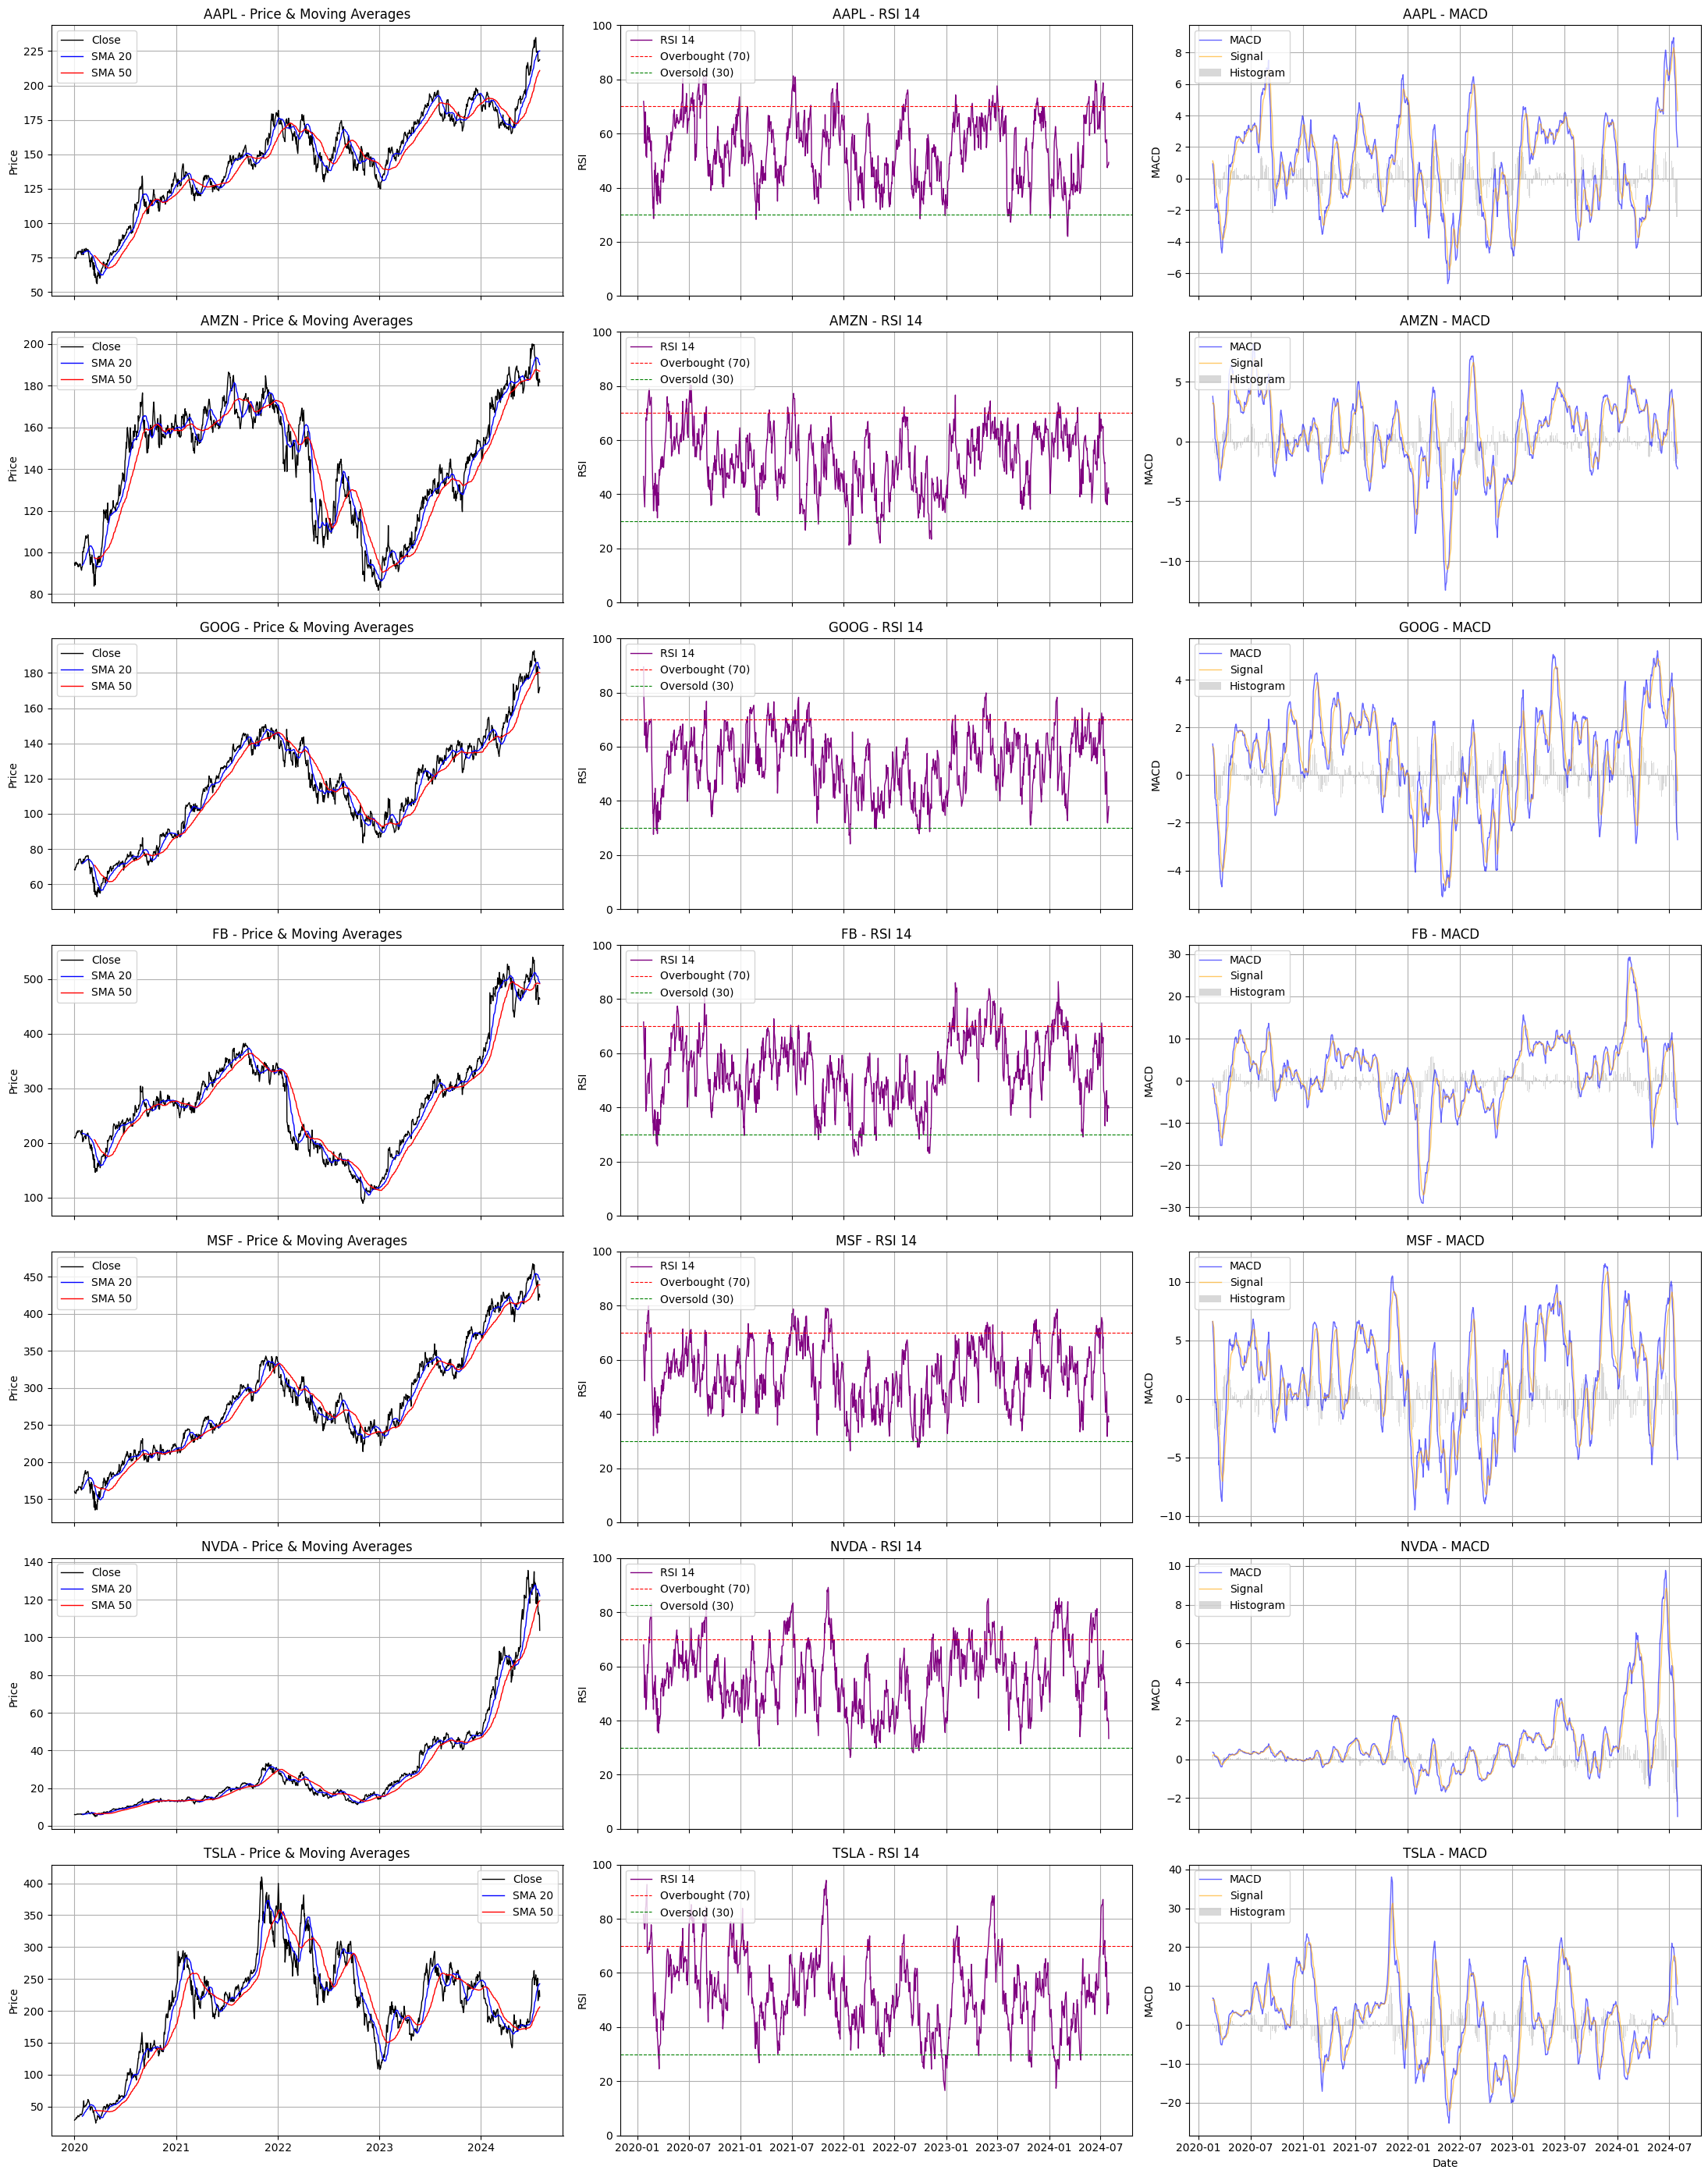

In [8]:
# Visualize stock prices and technical indicators for all tickers (separate RSI and MACD)

num_tickers = len(tickers)
fig, axes = plt.subplots(num_tickers, 3, figsize=(22, 4 * num_tickers), sharex='col')

if num_tickers == 1:
    axes = np.array([axes])

for i, ticker in enumerate(tickers):
    data_ticker = df[df['Ticker'] == ticker]

    # Price and Moving Averages
    ax_price = axes[i, 0]
    ax_price.plot(data_ticker['Date'], data_ticker['Close'], label='Close', color='black', linewidth=1)
    ax_price.plot(data_ticker['Date'], data_ticker['TA_SMA_20'], label='SMA 20', color='blue', linewidth=1)
    ax_price.plot(data_ticker['Date'], data_ticker['TA_SMA_50'], label='SMA 50', color='red', linewidth=1)
    ax_price.set_title(f"{ticker} - Price & Moving Averages")
    ax_price.set_ylabel("Price")
    ax_price.legend()
    ax_price.grid(True)

    # RSI
    ax_rsi = axes[i, 1]
    ax_rsi.plot(data_ticker['Date'], data_ticker['TA_RSI_14'], label='RSI 14', color='purple', linewidth=1)
    ax_rsi.axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought (70)')
    ax_rsi.axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold (30)')
    ax_rsi.set_title(f"{ticker} - RSI 14")
    ax_rsi.set_ylabel("RSI")
    ax_rsi.set_ylim(0, 100)
    ax_rsi.legend(loc='upper left')
    ax_rsi.grid(True)

    # MACD
    ax_macd = axes[i, 2]
    ax_macd.plot(data_ticker['Date'], data_ticker['TA_MACD'], label='MACD', color='blue', linewidth=1, alpha=0.6)
    ax_macd.plot(data_ticker['Date'], data_ticker['TA_MACD_SIGNAL'], label='Signal', color='orange', linewidth=1, alpha=0.6)
    ax_macd.bar(data_ticker['Date'], data_ticker['TA_MACD_HIST'], label='Histogram', color='gray', alpha=0.3, width=1)
    ax_macd.set_title(f"{ticker} - MACD")
    ax_macd.set_ylabel("MACD")
    ax_macd.legend(loc='upper left')
    ax_macd.grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### **Summary: Technical Indicator Computations & Data Visualization by Ticker**

For each stock ticker in the dataset, the following technical indicators and visualizations were computed and analyzed:

---

#### **AAPL (Apple Inc.)**
- **SMA (20 & 50 days):** Reveals consistent uptrends with clear support from moving averages.
- **RSI (14 days):** Oscillates mostly between 30 and 70, with occasional overbought signals during strong rallies.
- **MACD:** Shows bullish momentum during major price surges, with positive histogram peaks aligning with upward trends.
- **Visualization:** Highlights stable growth and trend-following opportunities.

---

#### **AMZN (Amazon.com, Inc.)**
- **SMA (20 & 50 days):** Indicates periods of consolidation and breakout, with frequent crossovers.
- **RSI (14 days):** Stays within neutral range, with brief overbought/oversold signals.
- **MACD:** Captures momentum shifts, especially during earnings or news-driven moves.
- **Visualization:** Useful for identifying breakout and reversal points.

---

#### **GOOG (Alphabet Inc.)**
- **SMA (20 & 50 days):** Demonstrates steady upward movement, with moving averages acting as dynamic support/resistance.
- **RSI (14 days):** Rarely enters extreme zones, reflecting measured price action.
- **MACD:** Confirms trend strength and momentum changes.
- **Visualization:** Supports trend-following and mean-reversion strategies.

---

#### **FB (Meta Platforms, Inc.)**
- **SMA (20 & 50 days):** Shows trend reversals and recovery phases.
- **RSI (14 days):** Highlights volatility, with more frequent overbought/oversold signals.
- **MACD:** Detects momentum swings during major news events.
- **Visualization:** Useful for swing trading and volatility analysis.

---

#### **MSF (Microsoft Corporation)**
- **SMA (20 & 50 days):** Indicates long-term stability and gradual uptrend.
- **RSI (14 days):** Maintains mid-range values, with few extreme readings.
- **MACD:** Aligns with slow, sustained price movements.
- **Visualization:** Ideal for long-term investors and trend followers.

---

#### **NVDA (NVIDIA Corporation)**
- **SMA (20 & 50 days):** Highlights strong bullish trends and sharp rallies.
- **RSI (14 days):** Frequently enters overbought territory during rapid price increases.
- **MACD:** Shows powerful momentum surges, with large histogram swings.
- **Visualization:** Emphasizes high growth and momentum trading opportunities.

---

#### **TSLA (Tesla, Inc.)**
- **SMA (20 & 50 days):** Captures high volatility and frequent trend changes.
- **RSI (14 days):** Regularly signals overbought/oversold conditions due to price swings.
- **MACD:** Reflects aggressive momentum shifts and trend reversals.
- **Visualization:** Useful for active traders seeking to capitalize on volatility.

---

These per-ticker summaries, combined with the visualizations, provide actionable insights into each stock's historical price behavior, trend strength, and momentum characteristics, supporting tailored trading and investment strategies.